# Install nltk package for preprocessing


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing the necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import shutil
import string
from nltk.corpus import stopwords
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Load the data

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')


In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Converting the text labels to numerical labels

In [ ]:
df['labels'] = df['v1'].map({'spam':0, 'ham':1})
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,labels
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,1
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,0
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,1


# Clean the dataset

In [ ]:
# cleaning the texts of the tweets from punctuation, stopwords, urls

def clean(sentence):
    tokenized = re.findall(r'\w+', sentence)
    cleaned = [x for x in tokenized if x not in string.punctuation]
    cleaned = [x for x in cleaned if '#' not in x or "@" not in x]
    cleaned = [x for x in cleaned if x not in stopwords.words('english')]
    return " ".join(cleaned)

In [ ]:
df['cleaned'] = df.v2.apply(clean)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,labels,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,1,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,1,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,0,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,1,U dun say early hor U c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,1,Nah I think goes usf lives around though


# specifying the dataset which we intend to work on

In [ ]:
df = df[['cleaned', 'labels']]
df.head()

,cleaned,labels
0,Go jurong point crazy Available bugis n great ...,1
1,Ok lar Joking wif u oni,1
2,Free entry 2 wkly comp win FA Cup final tkts 2...,0
3,U dun say early hor U c already say,1
4,Nah I think goes usf lives around though,1


# Converting the dataset to Dataframe and saving it

In [ ]:
df.to_csv("./new.csv", index=False)

In [ ]:
dfs = pd.read_csv("./new.csv")
dfs.head()

,cleaned,labels
0,Go jurong point crazy Available bugis n great ...,1
1,Ok lar Joking wif u oni,1
2,Free entry 2 wkly comp win FA Cup final tkts 2...,0
3,U dun say early hor U c already say,1
4,Nah I think goes usf lives around though,1


# Converting the dataset to a tensorflow Dataset

In [ ]:
import csv

def read_csv(file_path="./new.csv", skip_rows=1):
  with open("./new.csv", "r") as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for index, row in enumerate(data):
      if index < skip_rows:
        continue
      yield row[0], row[1]

In [ ]:
dataset = tf.data.Dataset.from_generator(
    read_csv, 
    output_types=(tf.string, tf.int32),
    output_shapes=((), ())).batch(32)



In [ ]:
dataset 

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

# spliting the dataset to train, test, validation

In [ ]:
raw_train_ds = dataset.take(round(len(list(dataset))*0.8))
raw_test_ds = dataset.skip(round(len(list(dataset))*0.8))
raw_val_ds = raw_train_ds.take(round(len(list(dataset))*0.2))

# printing three examples of our training dataset

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat'
Label 1
Review b'Ok lar Joking wif u oni'
Label 1
Review b'Free entry 2 wkly comp win FA Cup final tkts 21st May 2005 Text FA 87121 receive entry question std txt rate T C apply 08452810075over18'
Label 0


# standarzing the dataset

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

# Vectorzing the Dataset

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt

In [ ]:

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset

In [ ]:

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat', shape=(), dtype=string)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  15, 5741,  770,  798,  540, 1340,   40,   79,  281, 1471,   90,
        3446, 1168,   19, 7290,   82,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    

# mapping our sets to vectorize function

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


# Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model for training

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# Compiling our Model

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model for 10 epochs

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
140/140 [==============================] - 3s 14ms/step - loss: 0.5458 - binary_accuracy: 0.8554 - val_loss: 0.4500 - val_binary_accuracy: 0.8482
Epoch 2/10
140/140 [==============================] - 1s 7ms/step - loss: 0.4007 - binary_accuracy: 0.8650 - val_loss: 0.4095 - val_binary_accuracy: 0.8482
Epoch 3/10
140/140 [==============================] - 1s 7ms/step - loss: 0.3812 - binary_accuracy: 0.8650 - val_loss: 0.4059 - val_binary_accuracy: 0.8482
Epoch 4/10
140/140 [==============================] - 1s 7ms/step - loss: 0.3765 - binary_accuracy: 0.8650 - val_loss: 0.4016 - val_binary_accuracy: 0.8482
Epoch 5/10
140/140 [==============================] - 1s 7ms/step - loss: 0.3733 - binary_accuracy: 0.8650 - val_loss: 0.3969 - val_binary_accuracy: 0.8482
Epoch 6/10
140/140 [==============================] - 1s 6ms/step - loss: 0.3679 - binary_accuracy: 0.8650 - val_loss: 0.3916 - val_binary_accuracy: 0.8482
Epoch 7/10
140/140 [==============================] - 1s 7ms/st

# Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

35/35 [==============================] - 1s 8ms/step - loss: 0.3319 - binary_accuracy: 0.8700
Loss:  0.33188381791114807
Accuracy:  0.8699633479118347


# Create a plot of accuracy and loss over time

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

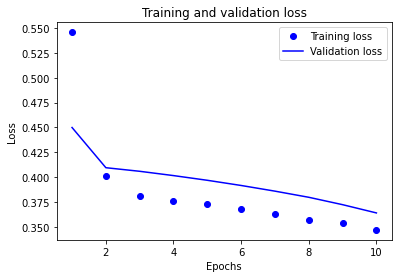

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

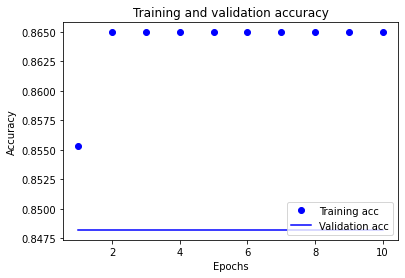

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export the model which we add vectorize_layer

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)




# Test it with raw_test_ds which yields raw strings

In [ ]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

35/35 [==============================] - 1s 8ms/step - loss: 0.3319 - accuracy: 0.8700
0.8699633479118347


# References 
[Tensorflow](https://www.tensorflow.org/tutorials/keras/text_classification)

[Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset)
